In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from keras.models import Model, Sequential
from tqdm import tqdm

from metrics import gmsd, psnr, ssim
from models.spectral_encoder import recon_model, ssim_loss
from loader.dataloader import DataLoader
from reg.reg_a import RegA
from reg.reg_b import RegB

DATA_DIR = "/Users/farhanoktavian/imperial/thesis/sandbox/dataset/raw"
METADATA_DIR = "/Users/farhanoktavian/imperial/thesis/sandbox/dataset/data.h5"

## Load Data

In [2]:
# Load data
run_loader = DataLoader(DATA_DIR, METADATA_DIR)

## Randomly select test images

In [3]:
rand_sample_idx = random.randint(0, len(run_loader.samples)-1)
sample = run_loader.samples[rand_sample_idx]

rand_run_idx = random.randint(0, len(sample.runs)-1)
run = sample.runs[rand_run_idx]

## Get Images

### By Green Channel

Text(0.5, 1.0, 'Target')

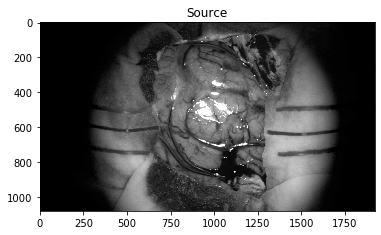

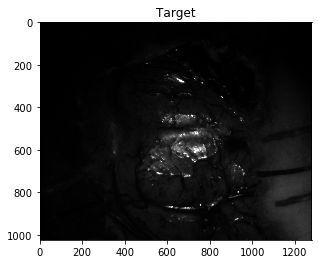

In [8]:
# Get images
img_source = run.get_label_image(channel="g")
img_target = run.get_spectral_image(wavelength=560, collection_idx=0)

fig, ax = plt.subplots()
ax.imshow(img_source, cmap="gray")
ax.set_title("Source")

fig, ax = plt.subplots()
ax.imshow(img_target, cmap="gray")
ax.set_title("Target")


### By Channel Inference

100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


Text(0.5, 1.0, 'Target R')

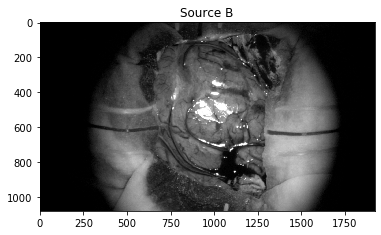

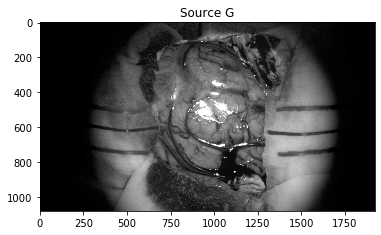

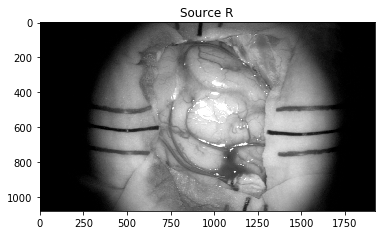

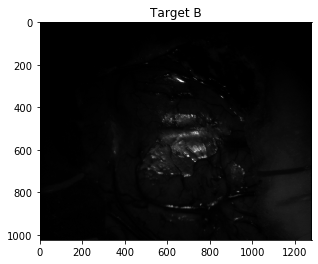

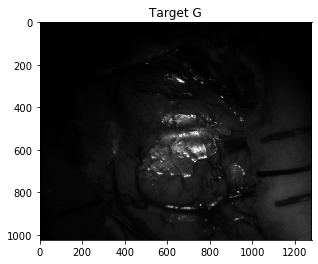

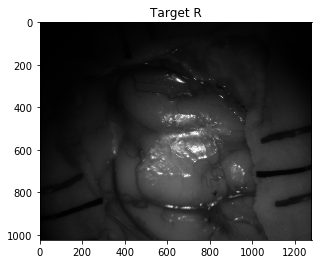

In [9]:
model = recon_model(input_shape=(None, None, 1))
model.load_weights("models/spectral_encoder.h5")
model.compile(optimizer="adam", loss=ssim_loss, metrics=["accuracy"])

encoder = Model(inputs=model.layers[0].input, outputs=model.layers[7].output)

decoder = Sequential()
for layer in model.layers[8:]:
    decoder.add(layer)

b_list = run.get_spectral_images(collection_idx=0, channel="b")
g_list = run.get_spectral_images(collection_idx=0, channel="g")
r_list = run.get_spectral_images(collection_idx=0, channel="r")

w, h = b_list[0].shape

b_feature_list = list()
for img in tqdm(b_list):
    img = np.array(img).reshape(-1, w, h, 1)
    img_feature = encoder.predict(img, verbose=0)
    b_feature_list.append(img_feature)

g_feature_list = list()
for img in tqdm(g_list):
    img = np.array(img).reshape(-1, w, h, 1)
    img_feature = encoder.predict(img, verbose=0)
    g_feature_list.append(img_feature)

r_feature_list = list()
for img in tqdm(r_list):
    img = np.array(img).reshape(-1, w, h, 1)
    img_feature = encoder.predict(img, verbose=0)
    r_feature_list.append(img_feature)

fuse_b = sum(b_feature_list) / len(b_feature_list)
img_target_b = decoder.predict(fuse_b, verbose=0)
img_target_b = img_target_b.reshape(w, h)
img_target_b = img_target_b.astype(np.uint8)

fuse_g = sum(g_feature_list) / len(g_feature_list)
img_target_g = decoder.predict(fuse_g, verbose=0)
img_target_g = img_target_g.reshape(w, h)
img_target_g = img_target_g.astype(np.uint8)

fuse_r = sum(r_feature_list) / len(r_feature_list)
img_target_r = decoder.predict(fuse_r, verbose=0)
img_target_r = img_target_r.reshape(w, h)
img_target_r = img_target_r.astype(np.uint8)

# Get images
img_source_b = run.get_label_image(channel="b")
img_source_g = run.get_label_image(channel="g")
img_source_r = run.get_label_image(channel="r")

fig, ax = plt.subplots()
ax.imshow(img_source_b, cmap="gray")
ax.set_title("Source B")

fig, ax = plt.subplots()
ax.imshow(img_source_g, cmap="gray")
ax.set_title("Source G")

fig, ax = plt.subplots()
ax.imshow(img_source_r, cmap="gray")
ax.set_title("Source R")

fig, ax = plt.subplots()
ax.imshow(img_target_b, cmap="gray")
ax.set_title("Target B")

fig, ax = plt.subplots()
ax.imshow(img_target_g, cmap="gray")
ax.set_title("Target G")

fig, ax = plt.subplots()
ax.imshow(img_target_r, cmap="gray")
ax.set_title("Target R")

## Try to register the test images

### By Green Channel

Text(0.5, 1.0, 'Merged: Reg A + Target')

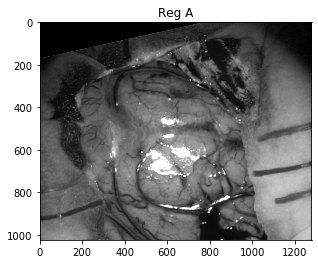

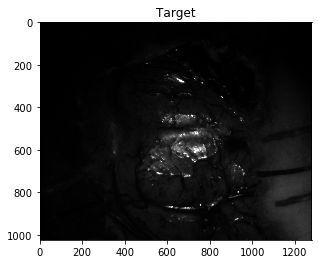

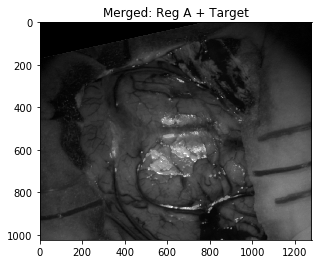

In [12]:
reg_1 = RegA(preprocessing_methods=["clahe"], matching_method="bf")
img_reg_1 = reg_1.register(img_source, img_target)

# reg_2 = RegB()
# img_reg_2, merged = reg_2.register(img_source, img_target)

fig, ax = plt.subplots()
ax.imshow(img_reg_1, cmap="gray")
ax.set_title("Reg A")

fig, ax = plt.subplots()
ax.imshow(img_target, cmap="gray")
ax.set_title("Target")

merge_reg_1 = img_reg_1 * 0.5 + img_target * 0.5
fig, ax = plt.subplots()
ax.imshow(merge_reg_1, cmap="gray")
ax.set_title("Merged: Reg A + Target")

# fig, ax = plt.subplots()
# ax.imshow(img_reg_2, cmap="gray")
# ax.set_title("Reg B")

# fig, ax = plt.subplots()
# ax.imshow(img_target, cmap="gray")
# ax.set_title("Target")

# merge_reg_2 = img_reg_2 * 0.5 + img_target * 0.5
# fig, ax = plt.subplots()
# ax.imshow(merge_reg_2, cmap="gray")
# ax.set_title("Merged: Reg B + Target")

### By Channel Inference

Text(0.5, 1.0, 'Target Red')

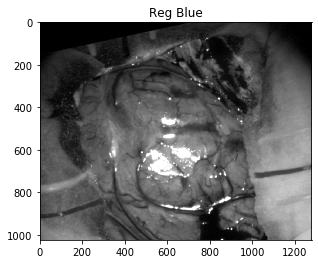

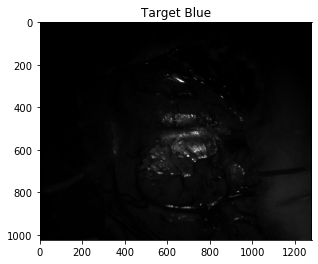

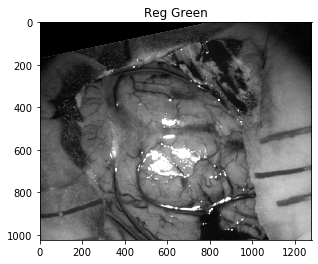

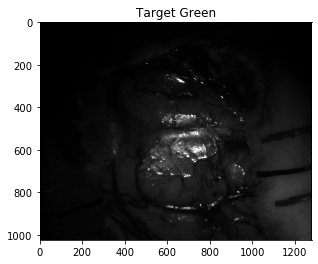

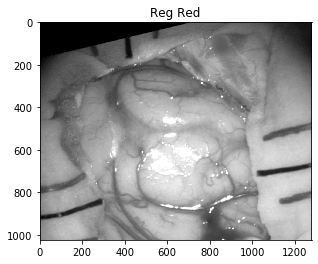

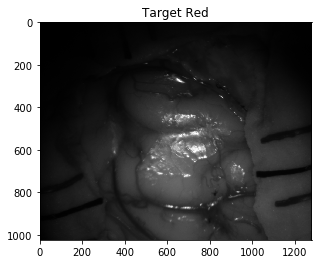

In [14]:
reg = RegA(preprocessing_methods=["clahe"], matching_method="bf")

img_reg_b = reg.register(img_source_b, img_target_b)
img_reg_g = reg.register(img_source_g, img_target_g)
img_reg_r = reg.register(img_source_r, img_target_r)

fig, ax = plt.subplots()
ax.imshow(img_reg_b, cmap="gray")
ax.set_title("Reg Blue")

fig, ax = plt.subplots()
ax.imshow(img_target_b, cmap="gray")
ax.set_title("Target Blue")

fig, ax = plt.subplots()
ax.imshow(img_reg_g, cmap="gray")
ax.set_title("Reg Green")

fig, ax = plt.subplots()
ax.imshow(img_target_g, cmap="gray")
ax.set_title("Target Green")

fig, ax = plt.subplots()
ax.imshow(img_reg_r, cmap="gray")
ax.set_title("Reg Red")

fig, ax = plt.subplots()
ax.imshow(img_target_r, cmap="gray")
ax.set_title("Target Red")


## Evaluation Score

gmsd:
Reg A: 0.135
Reg EncDec - channel blue: 0.133
Reg EncDec - channel green: 0.133
Reg EncDec - channel red: 0.106

psnr:
Reg A: 9.201
Reg EncDec - Channel blue: 8.995
Reg EncDec - Channel green: 9.703
Reg EncDec - Channel red: 7.029

ssim:
Reg A: 0.192
Reg EncDec - Channel blue: 0.148
Reg EncDec - Channel green: 0.252
Reg EncDec - Channel red: 0.337



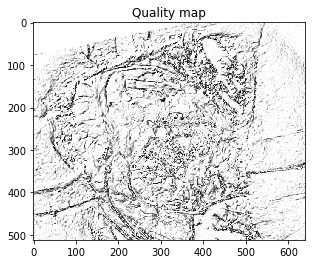

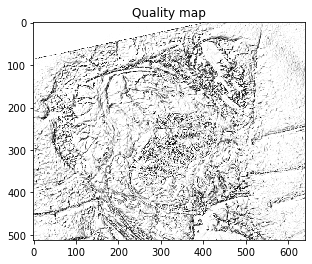

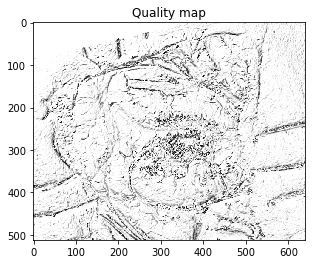

In [16]:
for ev in [gmsd, psnr, ssim]:
    img_reg_1_cp = img_reg_1.copy()
    # img_reg_2_cp = img_reg_2.copy()
    img_target_cp = img_target.copy()

    img_reg_b_cp = img_reg_b.copy()
    img_reg_g_cp = img_reg_g.copy()
    img_reg_r_cp = img_reg_r.copy()
    img_target_b_cp = img_target_b.copy()
    img_target_g_cp = img_target_g.copy()
    img_target_r_cp = img_target_r.copy()

    # Print metrics
    print(f"{ev.__name__}:")

    print(f"Reg A: {ev(img_reg_1_cp, img_target):.3f}")
    # fig, ax = plt.subplots()
    # ax.imshow(img_reg_a_cp, cmap="gray")
    # ax.set_title("Reg A")

    # print(f"Reg B: {ev(img_reg_2_cp, img_target):.3f}")
    # fig, ax = plt.subplots()
    # ax.imshow(img_reg_b_cp, cmap="gray")
    # ax.set_title("Reg B")

    if ev == gmsd:
        res, qmap = ev(img_reg_b_cp, img_target_b_cp, True)
        print(f"Reg EncDec - channel blue: {res:.3f}")

        qmap = qmap / np.max(qmap)
        qmap = np.uint8(qmap * 255)
        fig, ax = plt.subplots()
        ax.imshow(qmap, cmap="gray")
        ax.set_title("Quality map")

        res, qmap = ev(img_reg_g_cp, img_target_g_cp, True)
        print(f"Reg EncDec - channel green: {res:.3f}")

        qmap = qmap / np.max(qmap)
        qmap = np.uint8(qmap * 255)
        fig, ax = plt.subplots()
        ax.imshow(qmap, cmap="gray")
        ax.set_title("Quality map")

        res, qmap = ev(img_reg_r_cp, img_target_r_cp, True)
        print(f"Reg EncDec - channel red: {res:.3f}")

        qmap = qmap / np.max(qmap)
        qmap = np.uint8(qmap * 255)
        fig, ax = plt.subplots()
        ax.imshow(qmap, cmap="gray")
        ax.set_title("Quality map")
    else:
        print(f"Reg EncDec - Channel blue: {ev(img_reg_b_cp, img_target_b_cp):.3f}")
        print(f"Reg EncDec - Channel green: {ev(img_reg_g_cp, img_target_g_cp):.3f}")
        print(f"Reg EncDec - Channel red: {ev(img_reg_r_cp, img_target_r_cp):.3f}")

    print()